# Get Star Data

Use star data as long / lat and plot like a map

In [20]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import math
from matplotlib import font_manager

## Load and Merge Datasets

Load the stars datasets and merge as you would normally do

In [2]:
# load data
fp = os.path.join('..', 'Data', 'stars')

star_data = pd.read_csv(
    os.path.join(fp, 'asu.tsv'), sep = '\t', skiprows = 39
)
star_names = pd.read_csv(
    os.path.join(fp, 'IAU-Catalog of Star Names (2024).csv')
)


In [3]:
star_data = star_data[2:].copy().reset_index(drop = True)

In [4]:
# drop rows with missing locations
star_data = star_data[star_data['GLON'] != '      '].copy()

In [5]:
# convert to numeric
star_data['GLON'] = star_data['GLON'].astype(float)
star_data['GLAT'] = star_data['GLAT'].astype(float)
star_data['Vmag'] = star_data['Vmag'].astype(float)
star_data['HR'] = star_data['HR'].astype(int)

In [6]:
# make GLAT into lat / lon
star_data['gal_lat'] = star_data['GLAT']
star_data['gal_lon'] = star_data['GLON'].apply(lambda x: x if x < 180 else x - 360)

In [7]:
# Function to convert RA and Dec from H:M:S and D:M:S to degrees
def convert_to_degrees(ra_str, dec_str):
    # Convert RA from H:M:S to degrees
    ra_parts = list(map(float, ra_str.split()))
    ra_degrees = (ra_parts[0] * 15) + (ra_parts[1] * 15 / 60) + (ra_parts[2] * 15 / 3600)
    
    # Convert Dec from D:M:S to degrees
    dec_parts = list(map(float, dec_str.split()))
    if dec_parts[0] >= 0:
        dec_degrees = dec_parts[0] + (dec_parts[1] / 60) + (dec_parts[2] / 3600)
    else:  # If declination is negative
        dec_degrees = -(-dec_parts[0] + (dec_parts[1] / 60) + (dec_parts[2] / 3600))
    
    return ra_degrees, dec_degrees

# Apply the conversion to the DataFrame
star_data[['RA_Degrees', 'Dec_Degrees']] = star_data.apply(lambda row: convert_to_degrees(row['RAJ2000'], row['DEJ2000']), axis=1, result_type='expand')


In [8]:
# make this into equ_lat and equ_lon
star_data['eq_lat'] = star_data['Dec_Degrees']
star_data['eq_lon'] = star_data['RA_Degrees'].apply(lambda x: x if x < 180 else x - 360)

In [9]:
star_names_ext = star_names[['Proper Name', 'Designation']]
star_names_ext = star_names_ext[star_names_ext['Designation'].str.contains('HR')].copy()
star_names_ext['Designation'] = star_names_ext['Designation'].str.replace('HR ', '').astype(int)

In [10]:
# merge
star_data_merged = star_data.merge(
    star_names_ext,
    left_on = 'HR',
    right_on = 'Designation',
    how = 'left'
)

In [11]:
# example of extracting the brightest stars
star_data_merged[star_data_merged['Vmag'] < 1.5]

,HR,Name,HD,ADS,VarID,RAJ2000,DEJ2000,GLON,GLAT,Vmag,...,SpType,NoteFlag,gal_lat,gal_lon,RA_Degrees,Dec_Degrees,eq_lat,eq_lon,Proper Name,Designation
468,472,Alp Eri,10144,,Var,01 37 42.9,-57 14 12,290.84,-58.79,0.46,...,B3Vpe,*,-58.79,-69.16,24.428750,-57.236667,-57.236667,24.428750,Achernar,472.0
1453,1457,87Alp Tau,29139,3321,Alp Tau,04 35 55.2,+16 30 33,180.97,-20.25,0.85,...,K5+III,*,-20.25,-179.03,68.980000,16.509167,16.509167,68.980000,Aldebaran,1457.0
1703,1708,13Alp Aur,34029,3841,1897,05 16 41.4,+45 59 53,162.58,4.57,0.08,...,G5IIIe+G0III,*,4.57,162.58,79.172500,45.998056,45.998056,79.172500,Capella,1708.0
1708,1713,19Bet Ori,34085,3823,1882,05 14 32.3,-08 12 06,209.24,-25.25,0.12,...,B8Ia:,*,-25.25,-150.76,78.634583,-8.201667,-8.201667,78.634583,Rigel,1713.0
2055,2061,58Alp Ori,39801,4506,Alp Ori,05 55 10.3,+07 24 25,199.79,-8.96,0.50,...,M1-2Ia-Iab,*,-8.96,-160.21,88.792917,7.406944,7.406944,88.792917,Betelgeuse,2061.0
2320,2326,Alp Car,45348,,,06 23 57.1,-52 41 45,261.21,-25.29,-0.72,...,F0II,*,-25.29,-98.79,95.987917,-52.695833,-52.695833,95.987917,Canopus,2326.0
2484,2491,9Alp CMa,48915,5423,,06 45 08.9,-16 42 58,227.22,-8.88,-1.46,...,A1Vm,*,-8.88,-132.78,101.287083,-16.716111,-16.716111,101.287083,Sirius,2491.0
2936,2943,10Alp CMi,61421,6251,3672,07 39 18.1,+05 13 30,213.69,13.03,0.38,...,F5IV-V,*,13.03,-146.31,114.825417,5.225000,5.225000,114.825417,Procyon,2943.0
2983,2990,78Bet Gem,62509,6335,3712,07 45 18.9,+28 01 34,192.23,23.41,1.14,...,K0IIIb,*,23.41,-167.77,116.328750,28.026111,28.026111,116.328750,Pollux,2990.0
3973,3982,32Alp Leo,87901,7654,4750,10 08 22.3,+11 58 02,226.43,48.94,1.35,...,B7V,*,48.94,-133.57,152.092917,11.967222,11.967222,152.092917,Regulus,3982.0


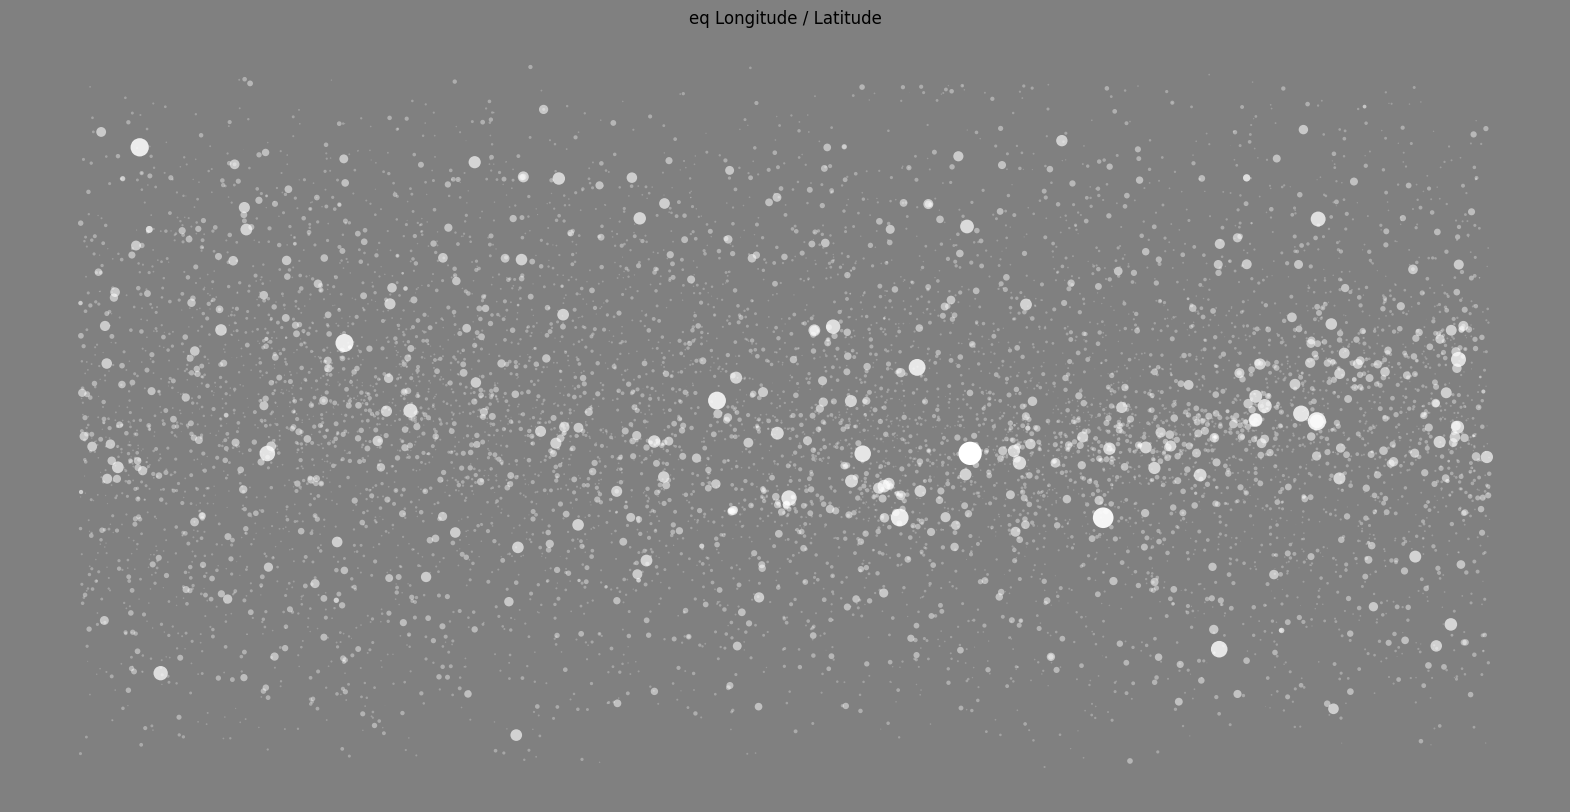

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Set background color to black
fig.patch.set_facecolor('gray')
ax.set_facecolor('gray')
ax.axis('off')

plt.scatter(
    x = star_data['GLON'],
    y = star_data['GLAT'],
    s = star_data['Vmag'].apply(lambda x: math.pow(8 - x, 3) / 3),
    alpha = 1 + (star_data['Vmag'].min() - star_data['Vmag']) / 10,
    edgecolors = 'none',
    color = 'white'
)

plt.title('eq Longitude / Latitude')

plt.show()

## Convert into GeoDataFrame

Now consider this as geospatial data

### Galactic System

In [13]:
# convert into GeoDataFrame
stars_gal_gdf = gpd.GeoDataFrame(
    star_data_merged,
    geometry = gpd.points_from_xy(star_data_merged['gal_lon'], star_data_merged['gal_lat'], crs = 'EPSG:4326')
)

### Equatorial System

In [ ]:
# convert into GeoDataFrame
stars_eq_gdf = gpd.GeoDataFrame(
    star_data_merged,
    geometry = gpd.points_from_xy(star_data_merged['eq_lon'], star_data_merged['eq_lat'], crs = 'EPSG:4326')
)

In [24]:
[f.name for f in font_manager.fontManager.ttflist]

['STIXSizeTwoSym',
 'DejaVu Sans Mono',
 'STIXSizeTwoSym',
 'cmmi10',
 'DejaVu Serif',
 'STIXNonUnicode',
 'DejaVu Sans',
 'cmtt10',
 'STIXGeneral',
 'STIXSizeFourSym',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'STIXSizeOneSym',
 'STIXSizeOneSym',
 'STIXSizeFiveSym',
 'cmb10',
 'DejaVu Sans Mono',
 'cmex10',
 'STIXSizeFourSym',
 'STIXSizeThreeSym',
 'STIXSizeThreeSym',
 'DejaVu Serif Display',
 'DejaVu Sans Display',
 'STIXNonUnicode',
 'STIXNonUnicode',
 'cmsy10',
 'cmss10',
 'DejaVu Sans',
 'DejaVu Sans',
 'DejaVu Serif',
 'STIXGeneral',
 'DejaVu Serif',
 'STIXGeneral',
 'cmr10',
 'STIXNonUnicode',
 'STIXGeneral',
 'DejaVu Sans Mono',
 'FOT-TsukuGo Pr5',
 'FOT-RodinWanpaku Pro',
 'Gill Sans Ultra Bold Condensed',
 'FOT-TsukuMin Pr5N',
 'A-OTF Ryumin Pro',
 'Leelawadee UI',
 'FOT-DotGothic16 Std',
 'Segoe UI',
 'HP Simplified',
 'FOT-RodinNTLG Pro',
 'Malgun Gothic',
 'FOT-RodinCattleya Pro',
 'Lucida Sans Typewriter',
 'HGSoeiKakupoptai',
 'FOT-KafuTechno Std',
 'Rockwel

In [15]:
plt.rcParams['font.sans-serif']

['DejaVu Sans',
 'Bitstream Vera Sans',
 'Computer Modern Sans Serif',
 'Lucida Grande',
 'Verdana',
 'Geneva',
 'Lucid',
 'Arial',
 'Helvetica',
 'Avant Garde',
 'sans-serif']

C:\Users\Soki\AppData\Local\Temp\ipykernel_22936\3161535487.py:90: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\Soki\AppData\Local\Temp\ipykernel_22936\3161535487.py:92: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig('../Maps/Day26.png', bbox_inches = 'tight')
C:\Users\Soki\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


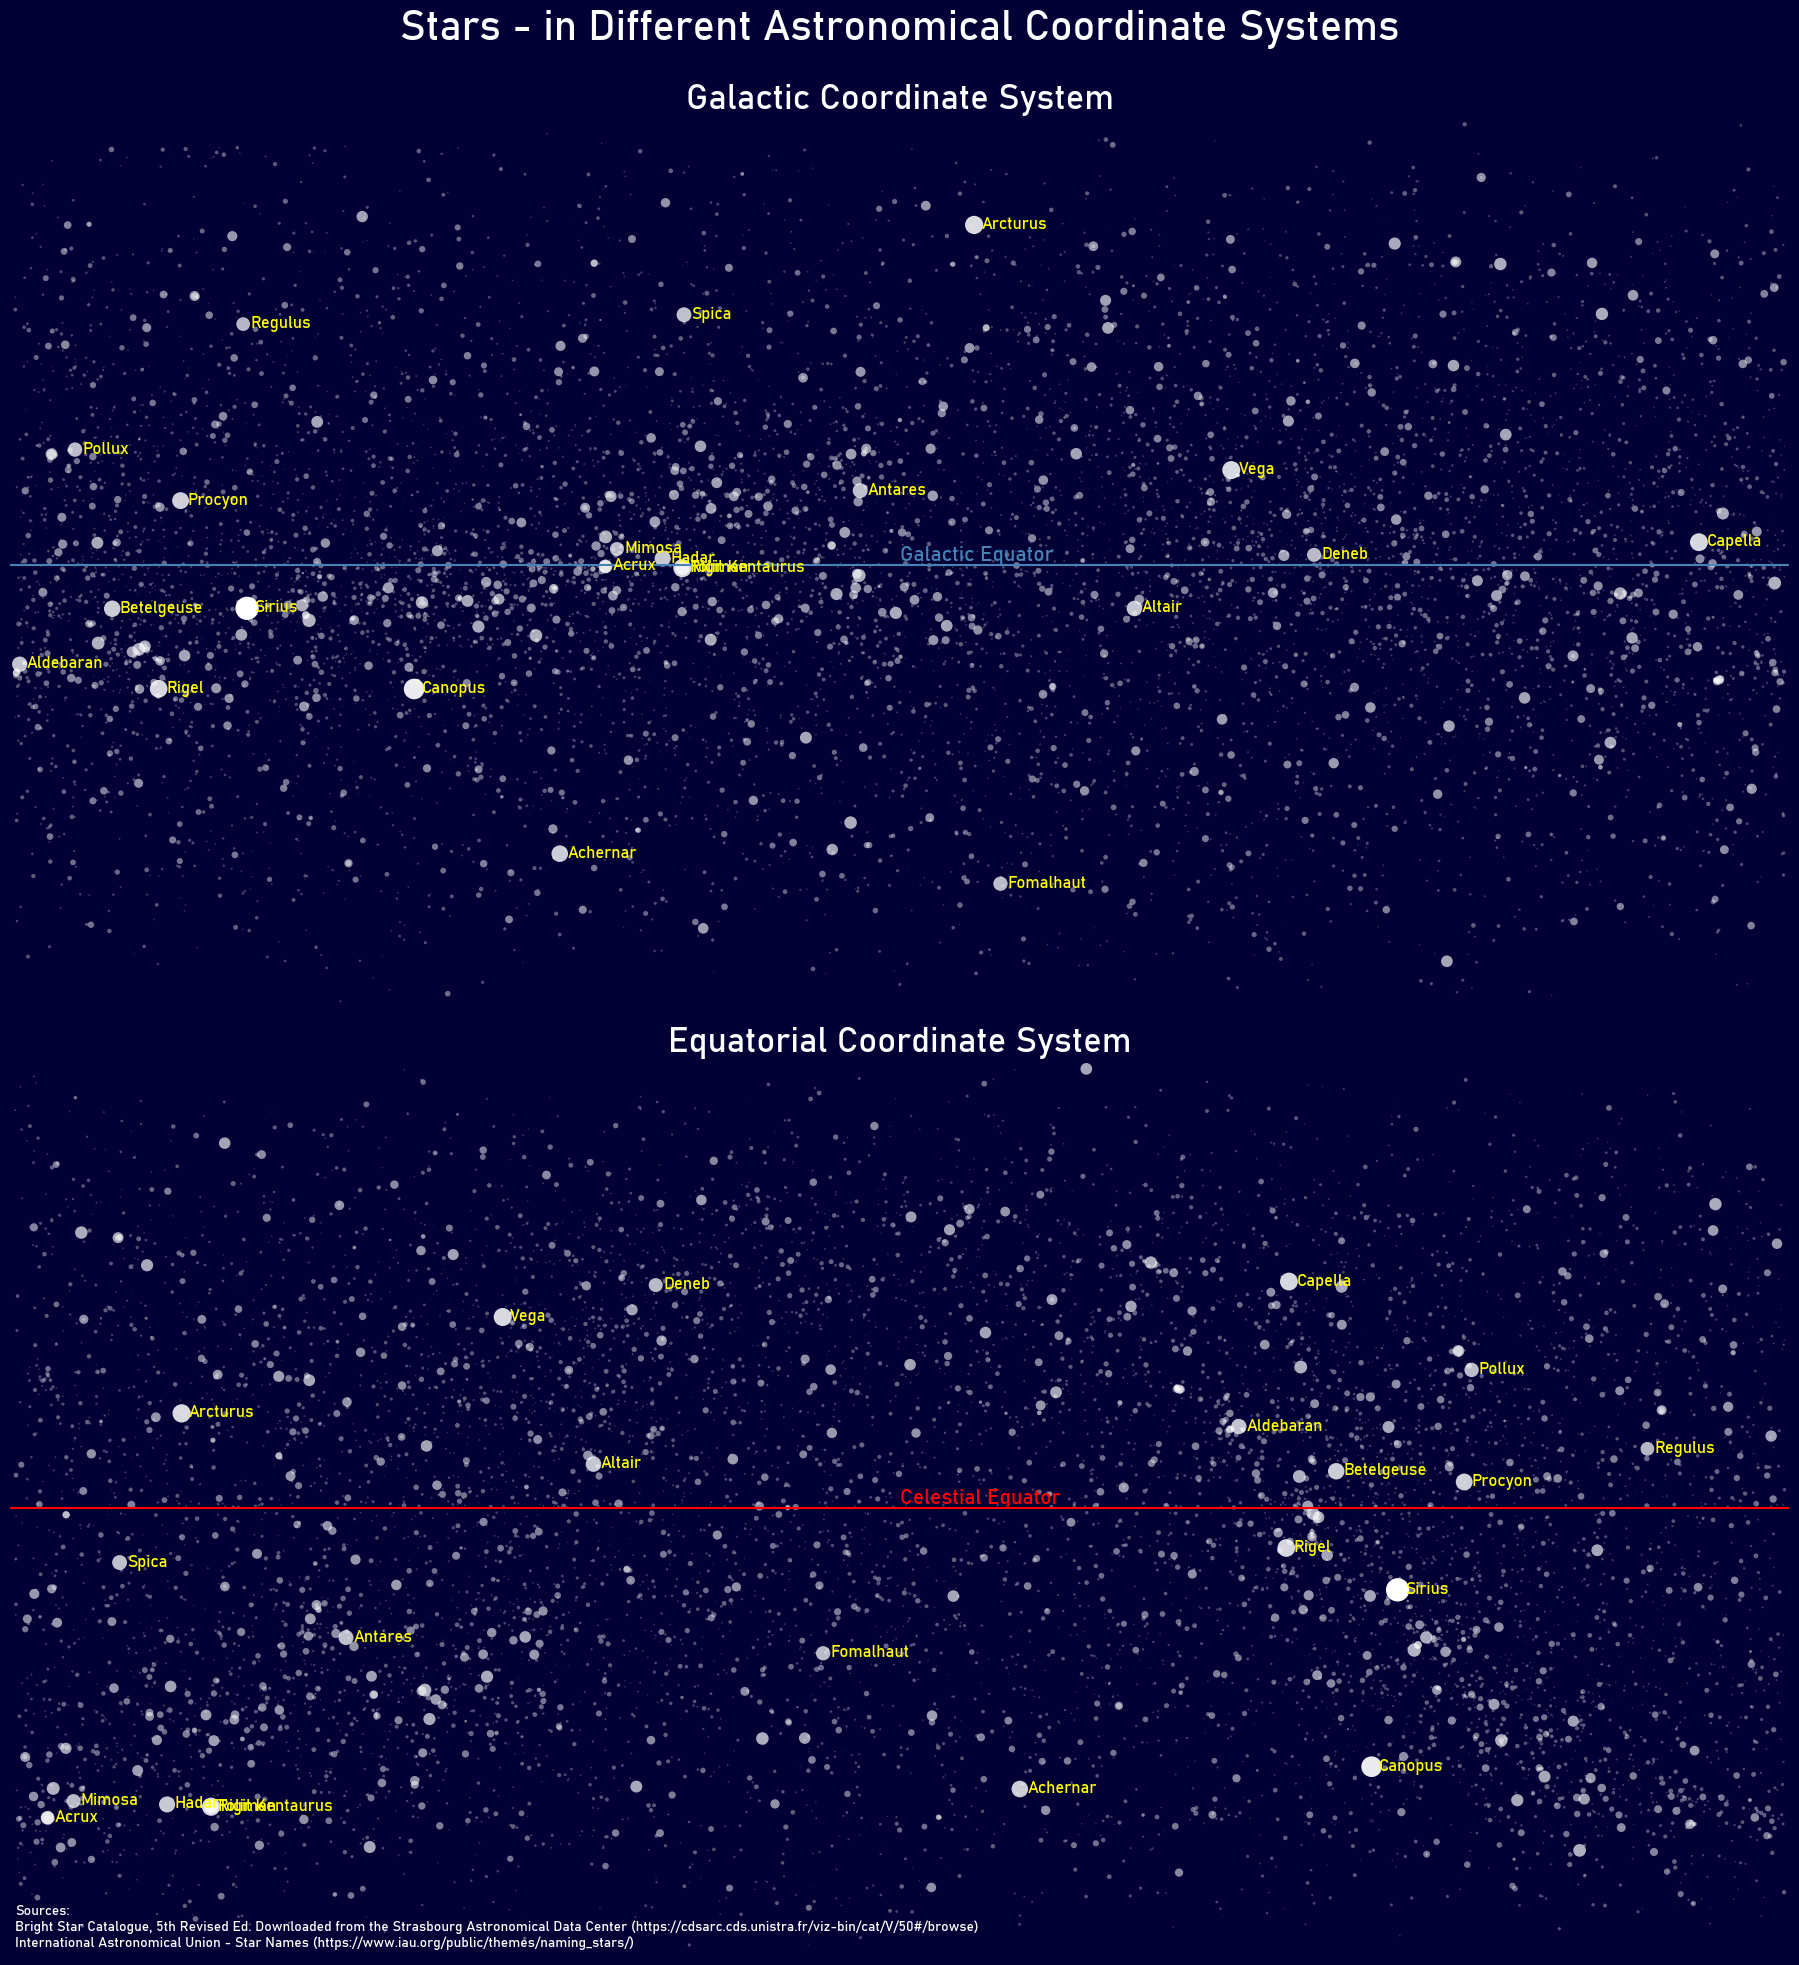

In [96]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Bahnschrift', 'DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']

fig, axes = plt.subplots(2, 1, figsize = (20, 20))

# Set background color to black
fig.patch.set_facecolor('xkcd:midnight blue')

for ax in axes:
    ax.set_facecolor('xkcd:midnight blue')
    ax.axis('off')
    ax.set_xlim(-181, 181)
    ax.set_ylim(-91, 91)

stars_gal_gdf.plot(
    ax = axes[0],
    markersize = stars_gal_gdf['Vmag'].apply(lambda x: math.pow(8 - x, 3) / 3),
    alpha = 1 + (stars_gal_gdf['Vmag'].min() - stars_gal_gdf['Vmag']) / 10,
    edgecolors = 'none',
    color = 'white'
)

axes[0].axhline(y = 0, color = 'steelblue')
axes[0].text(
    0, 0,
    'Galactic Equator',
    va = 'bottom',
    color = 'steelblue',
    fontsize = 15
)

# Add text labels to each point
for idx, row in stars_gal_gdf[stars_gal_gdf['Vmag'] < 1.5].iterrows():
    axes[0].text(
        row.geometry.x + 1.5, row.geometry.y,  # Use geometry for the coordinates
        str(row['Proper Name']),                 # Replace 'Label' with the column name containing labels
        color='yellow',                     # Label color
        fontsize = 12,                        # Font size for readability
        weight = 'bold',
        ha='left',                       # Horizontal alignment
        va='center'                        # Vertical alignment
    )


# ----- 2nd half -----

stars_eq_gdf.plot(
    ax = axes[1],
    markersize = stars_eq_gdf['Vmag'].apply(lambda x: math.pow(8 - x, 3) / 3),
    alpha = 1 + (stars_eq_gdf['Vmag'].min() - stars_eq_gdf['Vmag']) / 10,
    edgecolors = 'none',
    color = 'white'
)

axes[1].axhline(y = 0, color = 'red')
axes[1].text(
    0, 0,
    'Celestial Equator',
    va = 'bottom',
    color = 'red',
    fontsize = 15
)

# Add text labels to each point
for idx, row in stars_eq_gdf[stars_eq_gdf['Vmag'] < 1.5].iterrows():
    axes[1].text(
        row.geometry.x + 1.5, row.geometry.y,  # Use geometry for the coordinates
        str(row['Proper Name']),                 # Replace 'Label' with the column name containing labels
        color='yellow',                     # Label color
        fontsize = 12,                        # Font size for readability
        weight = 'bold',
        ha='left',                       # Horizontal alignment
        va='center'                        # Vertical alignment
    )

plt.suptitle('Stars - in Different Astronomical Coordinate Systems\n', fontsize = 30, color = 'white')

axes[0].set_title('Galactic Coordinate System', fontsize = 25, color = 'White')
axes[1].set_title('Equatorial Coordinate System', fontsize = 25, color = 'White')

axes[1].text(
    -180, -90,
    'Sources:\nBright Star Catalogue, 5th Revised Ed. Downloaded from the Strasbourg Astronomical Data Center (https://cdsarc.cds.unistra.fr/viz-bin/cat/V/50#/browse)\nInternational Astronomical Union - Star Names (https://www.iau.org/public/themes/naming_stars/)',
    color = 'white',
    fontsize = 10,
    va = 'bottom'
)

plt.margins(0.01)
plt.tight_layout()

plt.savefig('../Maps/Day26.png', bbox_inches = 'tight')

Text(0.5, 1.0, 'Stars - Equatorial Coordinate System')

C:\Users\Soki\AppData\Roaming\Python\Python311\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\Soki\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


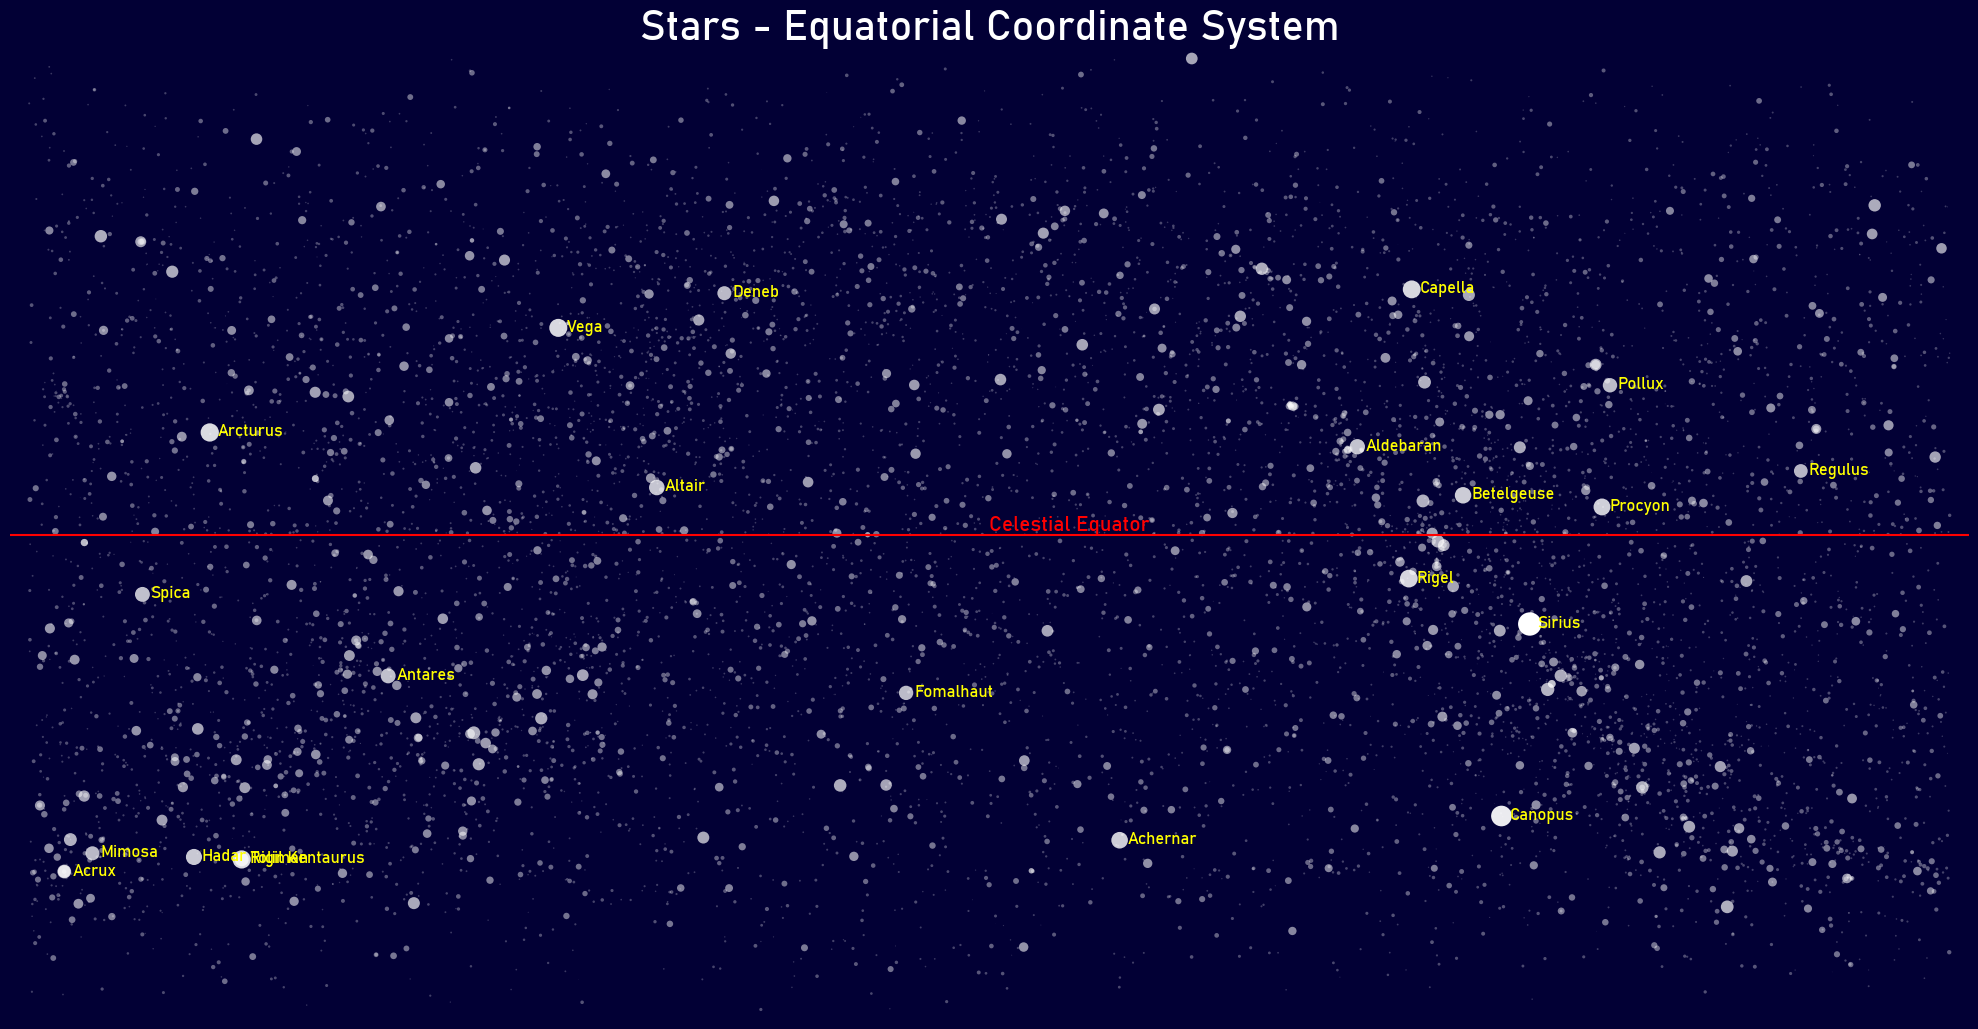

In [70]:
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Set background color to black
fig.patch.set_facecolor('xkcd:midnight blue')
ax.set_facecolor('black')
ax.axis('off')

stars_eq_gdf.plot(
    ax = ax,
    markersize = stars_eq_gdf['Vmag'].apply(lambda x: math.pow(8 - x, 3) / 3),
    alpha = 1 + (stars_eq_gdf['Vmag'].min() - stars_eq_gdf['Vmag']) / 10,
    edgecolors = 'none',
    color = 'white'
)

plt.axhline(y = 0, color = 'red')
ax.text(
    0, 0,
    'Celestial Equator',
    va = 'bottom',
    color = 'red',
    fontsize = 15
)

# Add text labels to each point
for idx, row in stars_eq_gdf[stars_eq_gdf['Vmag'] < 1.5].iterrows():
    ax.text(
        row.geometry.x + 1.5, row.geometry.y,  # Use geometry for the coordinates
        str(row['Proper Name']),                 # Replace 'Label' with the column name containing labels
        color='yellow',                     # Label color
        fontsize = 12,                        # Font size for readability
        weight = 'bold',
        ha='left',                       # Horizontal alignment
        va='center'                        # Vertical alignment
    )


plt.margins(0.01)
plt.tight_layout()

plt.title('Stars - Equatorial Coordinate System', fontsize = 30, color = 'White')
